## [Bonca99](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.60.1633)
Holstein Polaron. J. Bonča, S. A. Trugman, and I. Batistić. *Phys. Rev. B* **1999**, *60*, 1633.

In [1]:
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt
import tqdm

In [2]:
t = 1
lam = 1
omega = 1

In [3]:
class State:
    def __init__(self, e_state, ph_state):
        self.e_state: int = e_state
        self.ph_state: defaultdict = defaultdict(int, ph_state)
        self.centered_ph_state: defaultdict = defaultdict(int)
        self.center_left_ph_state: defaultdict = defaultdict(int)
        self.center_right_ph_state: defaultdict = defaultdict(int)
        for k, v in ph_state.items():
            self.centered_ph_state[k-e_state] = v
            self.center_left_ph_state[k-e_state-1] = v
            self.center_right_ph_state[k-e_state+1] = v
        self.total_phonon = sum(ph_state.values())
        sorted_keys = sorted(self.centered_ph_state)
        self._hash = hash(tuple(self.centered_ph_state[k] for k in sorted_keys))
    
    def __eq__(self, other):
        return self.centered_ph_state == other.centered_ph_state
    
    def __hash__(self):
        return self._hash
    
    def __repr__(self):
        return f"<State at 0x{id(self):x} e:{self.e_state}, ph:{list(self.ph_state.items())}>"

In [4]:
def ph_upper(ph, e):
    ph = ph.copy()
    ph[e] += 1
    return ph
    
def ph_lower(ph, e):
    if e not in ph:
        return
    ph = ph.copy()
    if ph[e] == 1:
        ph.pop(e)
    else:
        ph[e] -= 1
    return ph

In [5]:
root = State(0, {})

In [6]:
def expand(state: State):
    e = state.e_state
    ph = state.ph_state
    res = [State(e-1, ph), State(e+1, ph)]
    ph_up = ph_upper(ph, e)
    res.append(State(e, ph_up))
    ph_low = ph_lower(ph, e)
    if ph_low is not None:
        res.append(State(e, ph_low))
    return set(res)

In [7]:
state_collections = set([root])
n_round = 9
for i in range(n_round):
    orig_collection = state_collections.copy()
    for state in orig_collection:
        state_collections.update(expand(state))

In [8]:
len(state_collections)

1185

In [12]:
ndim = len(state_collections)
states = list(state_collections)

In [13]:
evals_list = []
for k in tqdm.tqdm(np.linspace(0, np.pi, 100)):
    def interaction(state1, state2):
        if state1 is state2 and len(state1.centered_ph_state) == 0:
            return - t * np.exp(-1j*k) -t * np.exp(1j*k)
        offset = state2.e_state - state1.e_state
        if state1.centered_ph_state == state2.centered_ph_state:
            return omega * state1.total_phonon * np.exp(1j * k * offset)
        state2_up = ph_upper(state2.centered_ph_state, 0)
        if state1.centered_ph_state == state2_up:
            return - np.sqrt(state2_up[0]) * lam * np.exp(1j * k * offset)
        state2_low = ph_lower(state2.centered_ph_state, 0)
        if state2_low is not None and state1.centered_ph_state == state2_low:
            return - np.sqrt(state2_low[0]+1) * lam * np.exp(1j * k * offset)
        if state1.centered_ph_state == state2.center_left_ph_state:
            return -t * np.exp(1j * k * (offset-1))
        if state1.centered_ph_state == state2.center_right_ph_state:
            return -t * np.exp(1j * k * (offset+1))
        return 0
    h = np.zeros((ndim, ndim), dtype=np.complex)
    for i, state1 in enumerate(states):
        for j, state2 in enumerate(states):
            h[i][j] = interaction(state1, state2)
    evals, evecs = np.linalg.eigh(h)
    evals_list.append(evals)
evals_array = np.array(evals_list)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:05<00:00,  7.26s/it]


(0, 3.141592653589793)

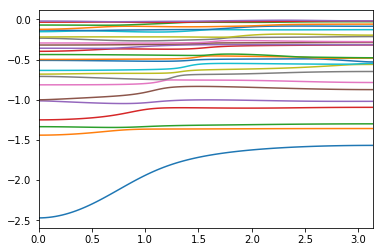

In [14]:
plt.plot(np.linspace(0, np.pi, 100), evals_array[:, :25])
plt.xlim(0, np.pi)